In [2]:
import torch.optim as optim
from torch import nn
from torch.utils import data
import torch
import torchvision
import torchvision.transforms as transforms
import math
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
import pickle
from torchsummary import summary
from skimage import io, transform

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [3]:
#All the parameters
epoch = 100
lr = 0.1
weight_decay = 0.0001
gamma = 0.95
resnet_type = {
    18: 'resnet18',
    34: 'resnet34',
    50: 'resnet50'
}

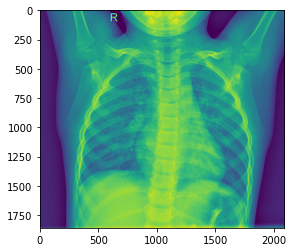

Image mode RGB
['NORMAL', 'PNEUMONIA']


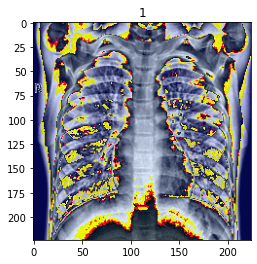

Image mode <built-in method mode of Tensor object at 0x00000227DED4B8B0>


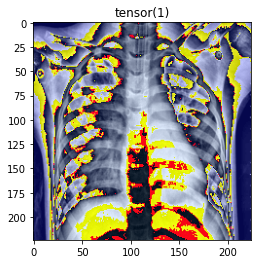

Image mode <built-in method mode of Tensor object at 0x00000227F3ABC9A0>


In [4]:
trainTransform = transforms.Compose([
    #transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomCrop(32, padding=4),
    transforms.Resize((224, 224)),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))
    ])

testTransform = transforms.Compose([ 
    transforms.Resize((224, 224)),
    transforms.Grayscale(3),   
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))])


#TO DO
#Add data loading

plt.imshow(io.imread("chest_xray/train/NORMAL/IM-0115-0001.jpeg"))
plt.show()


im = Image.open("chest_xray/train/NORMAL/IM-0115-0001.jpeg").convert('RGB')
print(f"Image mode {im.mode}")

trainSet = torchvision.datasets.ImageFolder("chest_xray/train", transform=trainTransform)
trainLoader = data.DataLoader(trainSet, 4, shuffle=True, num_workers=0)
testSet = torchvision.datasets.ImageFolder("chest_xray/test", transform=testTransform)
testLoader = data.DataLoader(testSet, 4, shuffle=True, num_workers=0)

print(trainSet.classes)

image, label = trainSet[4000]

plt.title(label)
plt.imshow(transforms.ToPILImage()(image).convert("RGB"))
plt.show()

print(f"Image mode {image.mode}")

image, label = next(iter(trainLoader))

plt.title(label[0])
plt.imshow(transforms.ToPILImage()(image[0]).convert("RGB"))
plt.show()

print(f"Image mode {image[0].mode}")

In [5]:
def evaluate(net, type, save_path):
    """
    Performs the evaluation of the current performance of a
    given convolutional network. It can perform the evaluation on 
    both training and testing sets. Standard evaluation metrics are
    calcualted such as, accuracy and confusion matrix.
    Parameters
    ----------
    net: ConvolutionalModel
        ConvNet whose performance needs to be evaluated.
    type: bool
        True if eval is made on testing set, false otherwise
    Return
    ------
    loss
        Current loss on the chosen set
    accuracy
        Current acc on the chosen set
    """
    device = torch.device('cuda')
    f = open(save_path, "a+")
    net.eval()
    total = 0
    correct = 0
    confMatrix = np.zeros((2, 2), int)
    lossFunc = nn.CrossEntropyLoss()
    accLoss = 0
    if type:
        with torch.no_grad():
            for data in testLoader:
                images, labels = data
                images = images.to(device=device)
                labels = labels.to(device=device)

                output = net.forward(images)
                loss = lossFunc(output, labels)
                _, predictions = torch.max(output.data, 1)
                total += labels.size(0)
                accLoss += loss.item()
                correct += (predictions == labels).sum().item()
                for j in range(labels.size(0)):
                    confMatrix[predictions[j], labels[j]] += 1
    else:
        with torch.no_grad():
            for data in trainLoader:
                images, labels = data
                images = images.to(device=device)
                labels = labels.to(device=device)

                output = net.forward(images)
                loss = lossFunc(output, labels)
                _, predictions = torch.max(output.data, 1)
                total += labels.size(0)
                accLoss += loss.item()
                correct += (predictions == labels).sum().item()
                for j in range(labels.size(0)):
                    confMatrix[predictions[j], labels[j]] += 1

    print("Accuracy of the neural network on CIFAR_100 is: %.2f %%" %((correct/total)*100))
    f.write("Accuracy: " + str(((correct/total)*100)) + '\n')
    f.write(str(trainSet.classes) + '\n')
    f.write(str(confMatrix) + '\n')
    prec, recall = specificMetrics(confMatrix)
    f.write(str(prec) + '\n')
    f.write(str(recall) + '\n')
    f.close()
    return (accLoss/(total/trainLoader.batch_size)), (correct/total)

def specificMetrics(confMatrix):
    """
    Calculates precision and recall from a given confusion
    matrix and returns calculated metrics.
    Parameters
    ----------
    confMatrix: n x n numpy array
        Made from the predictions and true labels of a
        given set of data
    Return
    ------
    precc
        Precision on all classes
    recal 
        Recall on all classes
    """
    precc = np.zeros(np.size(confMatrix, 0))
    recal = np.zeros(np.size(confMatrix, 0))
    for i in range(np.size(confMatrix, 0)):
        tp = 0
        fp = 0
        fn = 0
        for j in range(np.size(confMatrix, 0)):
            if i == j:
                tp += confMatrix[i, j]
            else:
                fn += confMatrix[j, i]
                fp += confMatrix[i, j]
            
        precc[i] += tp/(tp + fp)
        recal[i] += tp/(tp + fn)

    return precc, recal

In [6]:
def plot_training_progress(save_dir, data):
  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,8))

  linewidth = 2
  legend_size = 10
  train_color = 'm'
  val_color = 'c'

  num_points = len(data['train_loss'])
  x_data = np.linspace(1, num_points, num_points)
  ax1.set_title('Cross-entropy loss')
  ax1.plot(x_data, data['train_loss'], marker='o', color=train_color,
           linewidth=linewidth, linestyle='-', label='train')
  ax1.plot(x_data, data['valid_loss'], marker='o', color=val_color,
           linewidth=linewidth, linestyle='-', label='validation')
  ax1.legend(loc='upper right', fontsize=legend_size)
  ax2.set_title('Average class accuracy')
  ax2.plot(x_data, data['train_acc'], marker='o', color=train_color,
           linewidth=linewidth, linestyle='-', label='train')
  ax2.plot(x_data, data['valid_acc'], marker='o', color=val_color,
           linewidth=linewidth, linestyle='-', label='validation')
  ax2.legend(loc='upper left', fontsize=legend_size)
  ax3.set_title('Learning rate')
  ax3.plot(x_data, data['lr'], marker='o', color=train_color,
           linewidth=linewidth, linestyle='-', label='learning_rate')
  ax3.legend(loc='upper left', fontsize=legend_size)

  save_path = os.path.join(save_dir, 'plots/training_plot7.png')
  print('Plotting in: ', save_path)
  plt.savefig(save_path)

In [9]:
def trainNetwork():
    """Performs a standard procedure for training a neural network.
    Training progress after each learning epoch is evaluated in order to
    gain insigth into ConvNets continuous performance.
    Important notes
    ---------------
    Loss function: Cross entropy loss

    Optimizer: SGD
    
    Scheduler: MultiStepLR
    """
    plot_data = {}
    plot_data['train_loss'] = []
    plot_data['valid_loss'] = []
    plot_data['train_acc'] = []
    plot_data['valid_acc'] = []
    plot_data['lr'] = []
    SAVE_DIR = '/content/drive/MyDrive/Zavrsni'
    device = torch.device('cuda')

    model = torch.hub.load('pytorch/vision:v0.10.0', resnet_type[18] , pretrained=True)
    in_ftr  = model.fc.in_features
    model.fc = nn.Linear(in_ftr,1,bias=True)
    model.train()

    net = model.to(device=device)
    #summary(net, (3, 224, 224))

    lossFunc = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    schedulerExp = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    
    for e in range(epoch):
        print(f"Started epoch {e}")
    
        accLoss = 0.0

        for i, data in enumerate(trainLoader, 0):
            print(f"Started mini batch {i}")

            inputs, labels = data
            inputs = inputs.to(device=device)
            labels = labels.to(device=device)

            optimizer.zero_grad()

            outputs = net.forward(inputs)
            loss = lossFunc(outputs, labels.unsqueeze(1).float())
            loss.backward()
            optimizer.step()

            accLoss += loss.item()

            if i % 10 == 0:
                print("Epoch: %d, Iteration: %5d, Loss: %.3f" % ((e + 1), (i), (accLoss / (i + 1))))
                
        train_loss, train_acc = evaluate(net, False, os.path.join(SAVE_DIR, "eval/train_eval7"))
        val_loss, val_acc = evaluate(net, True, os.path.join(SAVE_DIR, "eval/test_eval7"))

        plot_data['train_loss'] += [train_loss]
        plot_data['valid_loss'] += [val_loss]
        plot_data['train_acc'] += [train_acc]
        plot_data['valid_acc'] += [val_acc]
        plot_data['lr'] += [schedulerExp.get_last_lr()]

        schedulerExp.step()
    
    val_loss, val_acc = evaluate(net, True, os.path.join(SAVE_DIR, "eval/final_eval7"))
    plot_training_progress(SAVE_DIR, plot_data)
    PATH = os.path.join(SAVE_DIR, "CIFAR_100/cifar_net7.pth")
    torch.save(net.state_dict(), PATH)

trainNetwork()

Using cache found in C:\Users\Dario/.cache\torch\hub\pytorch_vision_v0.10.0


Started epoch 0
Started mini batch 0
Epoch: 1, Iteration:     0, Loss: 0.886
Started mini batch 1
Started mini batch 2
Started mini batch 3
Started mini batch 4
Started mini batch 5
Started mini batch 6
Started mini batch 7
Started mini batch 8
Started mini batch 9
Started mini batch 10
Epoch: 1, Iteration:    10, Loss: 15.002
Started mini batch 11
Started mini batch 12
Started mini batch 13
Started mini batch 14
Started mini batch 15
Started mini batch 16
Started mini batch 17
Started mini batch 18
Started mini batch 19
Started mini batch 20
Epoch: 1, Iteration:    20, Loss: 11.417
Started mini batch 21
Started mini batch 22
Started mini batch 23
Started mini batch 24
Started mini batch 25
Started mini batch 26
Started mini batch 27
Started mini batch 28
Started mini batch 29
Started mini batch 30
Epoch: 1, Iteration:    30, Loss: 9.975
Started mini batch 31
Started mini batch 32
Started mini batch 33
Started mini batch 34
Started mini batch 35
Started mini batch 36
Started mini batch

KeyboardInterrupt: 